In [23]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain
import light_curve as lc
from astropy.table import MaskedColumn

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp


In [19]:
ztf_id_ref = 'ZTF22aaezyos'

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

In [37]:
ref_info.lightcurve

,time,alert_id,ant_mjd,ant_survey,ant_ra,ant_dec,ant_passband,ant_mag,ant_magerr,ant_maglim,ant_mag_corrected,ant_magerr_corrected,ant_magulim_corrected,ant_magllim_corrected
0,2022-04-03 07:40:58.998719,ztf_upper_limit:ZTF22aaezyos-1918320121015,59672.320127,2,NaN,NaN,g,NaN,NaN,20.854500,NaN,NaN,NaN,NaN
1,2022-04-03 07:53:49.004158,ztf_upper_limit:ZTF22aaezyos-1918329034915,59672.329039,2,NaN,NaN,g,NaN,NaN,20.783100,NaN,NaN,NaN,NaN
2,2022-04-06 05:21:08.003516,ztf_upper_limit:ZTF22aaezyos-1921223004915,59675.223009,2,NaN,NaN,R,NaN,NaN,20.194500,NaN,NaN,NaN,NaN
3,2022-04-06 07:48:17.003505,ztf_upper_limit:ZTF22aaezyos-1921325194915,59675.325197,2,NaN,NaN,g,NaN,NaN,20.497200,NaN,NaN,NaN,NaN
4,2022-04-06 08:15:22.999674,ztf_candidate:1921344011015015013,59675.344016,1,212.598737,44.233666,R,20.671900,0.232151,20.672300,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2022-06-28 06:20:50.000623,ztf_candidate:2004264464915015000,59758.264468,1,212.598981,44.233656,R,20.597700,0.325109,20.359800,NaN,NaN,NaN,NaN
129,2022-06-28 06:47:50.000647,ztf_candidate:2004283211015015014,59758.283218,1,212.598581,44.233628,R,20.510900,0.254482,20.448999,NaN,NaN,NaN,NaN
130,2022-06-30 05:22:18.998383,ztf_upper_limit:ZTF22aaezyos-2006223834915,59760.223831,2,NaN,NaN,g,NaN,NaN,20.707399,NaN,NaN,NaN,NaN
131,2022-06-30 05:27:02.001596,ztf_upper_limit:ZTF22aaezyos-2006227101015,59760.227106,2,NaN,NaN,g,NaN,NaN,20.701799,NaN,NaN,NaN,NaN


In [20]:
df_ref

,ant_dec,ant_input_msg_time,ant_mag,ant_magerr,ant_maglim,ant_mjd,ant_passband,ant_ra,ant_survey,ant_time_received,...,ztf_sumrat,ztf_szmag1,ztf_szmag2,ztf_szmag3,ztf_tblid,ztf_tooflag,ztf_xpos,ztf_ypos,ztf_zpclrcov,ztf_zpmed
time,,,,,,,,,,,,,,,,,,,,,
2022-04-03 07:40:58.998719,NaN,1649570091,NaN,NaN,20.854500,59672.320127,g,NaN,2,1649570091,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2022-04-03 07:53:49.004158,NaN,1649570091,NaN,NaN,20.783100,59672.329039,g,NaN,2,1649570091,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2022-04-06 05:21:08.003516,NaN,1649570091,NaN,NaN,20.194500,59675.223009,R,NaN,2,1649570091,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2022-04-06 07:48:17.003505,NaN,1649570091,NaN,NaN,20.497200,59675.325197,g,NaN,2,1649570091,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2022-04-06 08:15:22.999674,44.233666,1649570091,20.671900,0.232151,20.672300,59675.344016,R,212.598737,1,1649570091,...,0.921127,NaN,NaN,NaN,13,<NA>,1622.150024,2287.050049,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-28 06:20:50.000623,44.233656,1656570613,20.597700,0.325109,20.359800,59758.264468,R,212.598981,1,1656570613,...,1.000000,NaN,NaN,NaN,0,<NA>,2126.169922,38.770699,NaN,NaN
2022-06-28 06:47:50.000647,44.233628,1656570613,20.510900,0.254482,20.448999,59758.283218,R,212.598581,1,1656570613,...,0.931235,NaN,NaN,NaN,14,<NA>,1649.250000,2239.159912,NaN,NaN
2022-06-30 05:22:18.998383,NaN,1656570613,NaN,NaN,20.707399,59760.223831,g,NaN,2,1656570613,...,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN


In [21]:
df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

<ErrorbarContainer object of 3 artists>

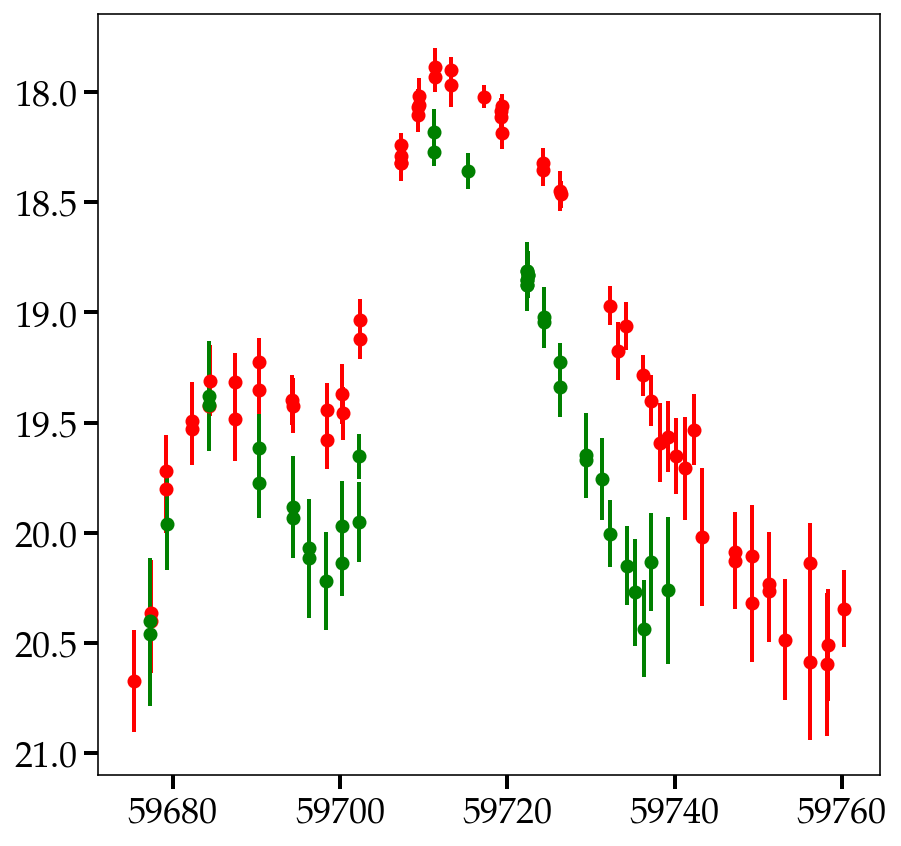

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
plt.gca().invert_yaxis()

ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}')
ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# Extract LC features

In [102]:
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

min_obs_count=4
cls_name='BaseFeatures'

lightcurve = ref_info.lightcurve
feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)
lc_properties_d={}
for band, names in property_names.items():
    detections = get_detections(lightcurve, band)

    # Ensure locus has >3 obs for calculation
    if (len(detections) < min_obs_count):
        continue

    # if we have >= 4 observations, calculate features!
    t = detections['ant_mjd'].values
    m = detections['ant_mag'].values
    merr = detections['ant_magerr'].values
    flux = np.power(10.0, -0.4 * m)
    fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

    magn_features = MAGN_EXTRACTOR(
        t,
        m,
        merr,
        sorted=None,
        fill_value=None,
    )
    flux_features = FLUX_EXTRACTOR(
        t,
        flux,
        fluxerr,
        sorted=None,
        fill_value=None,
    )

    # After successfully calculating features, set locus properties and tag
    lc_properties_d["ztf_object_id"] = ztf_id_ref
    for name, value in zip(names, chain(magn_features, flux_features)):
        lc_properties_d[name] = value

In [103]:
lc_properties_d

{'ztf_object_id': 'ZTF22aaezyos',
 'feature_amplitude_magn_r': 1.3932371139526367,
 'feature_anderson_darling_normal_magn_r': 1.6877939426721058,
 'feature_beyond_1_std_magn_r': 0.5230769230769231,
 'feature_beyond_2_std_magn_r': 0.0,
 'feature_cusum_magn_r': 0.4197839289248115,
 'feature_eta_e_magn_r': 8178.031335293724,
 'feature_inter_percentile_range_2_magn_r': 2.7172283744598644,
 'feature_inter_percentile_range_10_magn_r': 2.307676315307617,
 'feature_inter_percentile_range_25_magn_r': 1.5338950157165527,
 'feature_kurtosis_magn_r': -1.2132269751648803,
 'feature_linear_fit_slope_magn_r': 0.0029855851955507416,
 'feature_linear_fit_slope_sigma_magn_r': 0.0008373465040412557,
 'feature_linear_fit_reduced_chi2_magn_r': 44.866528761492575,
 'feature_linear_trend_magn_r': 0.00861720808504214,
 'feature_linear_trend_sigma_magn_r': 0.004182899541538382,
 'feature_linear_trend_noise_magn_r': 0.8368031172846209,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0.1120693254408224,
 'fea

In [128]:
feats = ['feature_amplitude_magn_r',
 'feature_anderson_darling_normal_magn_r',
 'feature_beyond_1_std_magn_r',
 'feature_beyond_2_std_magn_r',
 'feature_cusum_magn_r',
 'feature_inter_percentile_range_2_magn_r',
 'feature_inter_percentile_range_10_magn_r',
 'feature_inter_percentile_range_25_magn_r',
 'feature_kurtosis_magn_r',
 'feature_linear_fit_slope_magn_r',
 'feature_linear_fit_slope_sigma_magn_r',
 'feature_magnitude_percentage_ratio_40_5_magn_r',
 'feature_magnitude_percentage_ratio_20_5_magn_r',
 'feature_mean_magn_r',
 'feature_median_absolute_deviation_magn_r',
 'feature_percent_amplitude_magn_r',
 'feature_median_buffer_range_percentage_10_magn_r',
 'feature_median_buffer_range_percentage_20_magn_r',
 'feature_percent_difference_magnitude_percentile_5_magn_r',
 'feature_percent_difference_magnitude_percentile_10_magn_r',
 'feature_skew_magn_r',
 'feature_standard_deviation_magn_r',
 'feature_stetson_k_magn_r',
 'feature_weighted_mean_magn_r',
 'feature_anderson_darling_normal_flux_r',
 'feature_cusum_flux_r',
 'feature_excess_variance_flux_r',
 'feature_kurtosis_flux_r',
 'feature_mean_variance_flux_r',
 'feature_skew_flux_r',
 'feature_stetson_k_flux_r',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation_magn_g',
 'feature_median_buffer_range_percentage_10_magn_g',
 'feature_median_buffer_range_percentage_20_magn_g',
 'feature_percent_amplitude_magn_g',
 'feature_percent_difference_magnitude_percentile_5_magn_g',
 'feature_percent_difference_magnitude_percentile_10_magn_g',
 'feature_skew_magn_g',
 'feature_standard_deviation_magn_g',
 'feature_stetson_k_magn_g',
 'feature_weighted_mean_magn_g',
 'feature_anderson_darling_normal_flux_g',
 'feature_cusum_flux_g',
 'feature_excess_variance_flux_g',
 'feature_kurtosis_flux_g',
 'feature_mean_variance_flux_g',
 'feature_skew_flux_g',
 'feature_stetson_k_flux_g']

drop_feat_cols = ['feature_eta_e_magn_r',
                 'feature_linear_fit_reduced_chi2_magn_r', 
                 'feature_linear_trend_magn_r', # cadence removal
                 'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_linear_trend_noise_magn_r',  # cadence removal
                 'feature_maximum_slope_magn_r',
                 'feature_period_0_magn_r',  # should be negated
                 'feature_period_s_to_n_0_magn_r', # cadence removal
                 'feature_period_1_magn_r', 
                 'feature_period_s_to_n_1_magn_r', # cadence removal
                 'feature_period_2_magn_r', 
                 'feature_period_s_to_n_2_magn_r', # cadence removal
                 'feature_period_3_magn_r', 
                 'feature_period_s_to_n_3_magn_r', # cadence removal
                 'feature_period_4_magn_r', 
                 'feature_period_s_to_n_4_magn_r', # cadence removal
                 'feature_periodogram_amplitude_magn_r',
                 'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 'feature_chi2_magn_r',
                 'feature_eta_e_flux_r', 
                 'feature_chi2_flux_r', 
                 'feature_eta_e_magn_g',
                 'feature_linear_fit_reduced_chi2_magn_g', 
                 'feature_linear_trend_magn_g', # cadence removal
                 'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_linear_trend_noise_magn_g',
                 'feature_maximum_slope_magn_g', 
                 'feature_period_0_magn_g',  # should be negated
                 'feature_period_s_to_n_0_magn_g', # cadence removal
                 'feature_period_1_magn_g', 
                 'feature_period_s_to_n_1_magn_g', # cadence removal
                 'feature_period_2_magn_g', 
                 'feature_period_s_to_n_2_magn_g', # cadence removal
                 'feature_period_3_magn_g', 
                 'feature_period_s_to_n_3_magn_g', # cadence removal
                 'feature_period_4_magn_g', 
                 'feature_period_s_to_n_4_magn_g', # cadence removal
                 'feature_periodogram_amplitude_magn_g',
                 'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 'feature_chi2_magn_g',
                 'feature_eta_e_flux_g', 
                 'feature_chi2_flux_g',]

In [129]:
len(feats)

62

In [130]:
lc_properties_df = pd.DataFrame.from_dict(lc_properties_d, orient='index').T
#lc_properties_df.set_index('ztf_object_id')

lc_properties_df = lc_properties_df.drop(columns=drop_feat_cols)
lc_properties_df.set_index('ztf_object_id')

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_standard_deviation_magn_g,feature_stetson_k_magn_g,feature_weighted_mean_magn_g,feature_anderson_darling_normal_flux_g,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF22aaezyos,1.393237,1.687794,0.523077,0.0,0.419784,2.717228,2.307676,1.533895,-1.213227,0.002986,...,0.633972,0.849442,19.156785,3.057415,0.374965,0.473121,2.447206,0.702371,1.711143,0.761926


# scale and normalize values!

# Get GHOST features